# Covid19 Analysis and Prediction for US
## by Tim Hickey on Mon 3/23/2020
In this jupyter notebook we take the current US covid-19 data from covidtracking.com
and plot it with a vertical log scale.  The growth of the number of cases and deaths
are seen to be very nearly exponential with
deaths = 3.1 * 1.31*k  where k is the number of days after 3/3/2020

At this rate, by day 47 there will a million US deaths and everyone will be infected.
That is sometime in mid-April.

We will track these curves an predictions and hope that they change radically.

First we need to import some libraries

In [1]:
import math
import json
import numpy
import matplotlib.pyplot as plt

Next we read in the data from a file
We should modify this to read the data in from the online webservice
so it will be up to date...

In [2]:
with open('uscovid19.json') as f:
  data = json.load(f)
print(len(data))
print(data[0])


19
{'date': 20200304, 'states': 14, 'positive': 118, 'negative': 748, 'posNeg': 866, 'pending': 103, 'hospitalized': None, 'death': None, 'total': 969}


Now we clean up the data a bit (replace None values with 0)
and we get the values for the number of positive cases and the deaths
These are lists where the element at position k is the number of cases or deaths
on day k after 3/3/2020

In [3]:
def clean(n):
    if n==None:
        return 0
    else:
        return n

positives = [clean(x['positive']) for x in data]
deaths = [clean(x['death']) for x in data]
dates = [clean(x['date']) for x in data]
deaths

[0, 0, 0, 0, 0, 0, 0, 27, 36, 39, 49, 60, 71, 90, 112, 160, 219, 322, 398]

We can now plot the data using matplotlib.pyplot which has been imported as plt

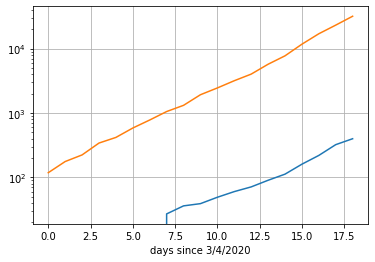

In [4]:
fig, ax = plt.subplots()
line1, = ax.plot(deaths)
line2, = ax.plot(positives)
plt.yscale('log')
plt.grid(True)
plt.xlabel('days since 3/4/2020')


plt.show()


Next we make a rough calculation of the average rate of increase per day over the past week to get the daily increase ratio for deaths and cases and we use it to see how accurately in predicts todays deaths/cases starting from a week ago.

In [5]:
# calulate d = death increase per day ratio
d_death = math.exp(math.log(deaths[-1]/deaths[-8])/7)
print(d_death)
print(deaths[-8:])
print(deaths[-8]*d_death**7)
n_death = len(deaths)

1.3103588923195821
[60, 71, 90, 112, 160, 219, 322, 398]
398.0000000000001


In [6]:
# calulate d = death increase per day ratio
d_pos = math.exp(math.log(positives[-1]/positives[-8])/7)
print(d_pos)
print(positives[-8:])
print(round(positives[-8]*d_pos**7))
n_pos = len(positives)

1.3904818219188846
[3173, 4019, 5723, 7731, 11723, 17038, 23203, 31888]
31888


We can now start to make a prediction, since we have the daily rate of increase for deaths and cases. 
We also calculate the constant value to represent these as pure exponentials
``` python
f(k) = c * d**k
```


In [7]:
days=60
death_prediction = [round(deaths[-1]*d_death**(k-n_death+1)) for k in range(n_death,n_death+days)]
#print(death_prediction)
positive_prediction = [round(positives[-1]*d_pos**(k-n_pos+1)) for k in range(n_pos,n_pos+days)]
#print(positive_prediction)
c_pos = positives[-1]*d_pos**(1-n_pos)
print('c_pos',c_pos)
print('d_pos',d_pos)
c_death = deaths[-1]*d_death**(1-n_death)
print('c_death',c_death)
print('d_death',d_death)

c_pos 84.4601017741033
d_pos 1.3904818219188846
c_death 3.0680214223120013
d_death 1.3103588923195821


Finally, we plot our predictions and also draw lines at on million, 330 million (the US population), and 7.53 billion (the world population)

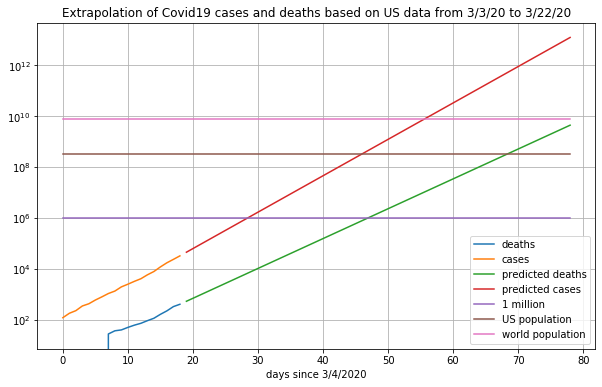

[10.0, 6.0]

In [8]:
plt.rcParams['figure.figsize'] = [10.0,6.0]
fig2, ax = plt.subplots()

line1, = ax.plot(deaths)
line2, = ax.plot(positives)
line3, = ax.plot(range(n_death,n_death+days),death_prediction)
line4, = ax.plot(range(n_pos,n_pos+days), positive_prediction)
line5, = ax.plot(range(0,n_pos+days),[1000000]*(n_pos+days))
line6, = ax.plot(range(0,n_pos+days),[330000000]*(n_pos+days))
line7, = ax.plot(range(0,n_pos+days),[7.53*10**9]*(n_pos+days))
# here we can plot our approximation of the deaths graph as a pure exponential function
#line8, = ax.plot(range(0,n_death+days),[c_death*d_death**k for k in range(0,n_pos+days)])
#line9, = ax.plot(range(0,n_pos+days),[c_pos*d_pos**k for k in range(0,n_pos+days)])
plt.yscale('log')
plt.grid(True)
plt.xlabel('days since 3/4/2020')
plt.legend(['deaths','cases','predicted deaths','predicted cases','1 million','US population','world population'])
plt.title("Extrapolation of Covid19 cases and deaths based on US data from 3/3/20 to 3/22/20")

plt.savefig('covid19.png')
plt.show()
plt.rcParams['figure.figsize']